In [5]:
# This is the simulation of our evolving RS model under the SECOND framework of our assumptions on edge weights.
import numpy as np
import random
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd

In [7]:
#Initial settings of parameters in our weighted bipartite graph model B(U,I).
beta = 0.6 # the probability to add a new vertex in U
iterations = 3000 # the number of iterations to run the simulation
rating_scale = 5 # the preassigned rating scale
Cu = 10 # the least number of edges connected to vertices in U
Ci = 20 # the least number of edges connected to vertices in I
Unum = 20 # the number of vertices in U in the initial graph at t=0
Inum = 10 # the number of vertices in I in the initial graph at t=1
K = 10 # the number of basic user type in our assumption
L = 3 # the number of basic item level in our assumption
Hui = np.zeros((rating_scale,K,L)) # the rating pmf for the pair of K user types and L item levels
Fmean = np.zeros((K,)) # the mean of the distribution of users' weight vector (assumed to be Gaussian)
Gmean = np.zeros((L,)) # the mean of the distribution of items' weight vector (assumed to be Gaussian)
edges = np.zeros((iterations+50,iterations+50), dtype=int) # the matrix storing edge information
Uweight = np.zeros((iterations+50,K)) # the matrix storing users' weight vectors
Iweight = np.zeros((iterations+50,L)) # the matrix storing items' weight vectors

In [8]:
# Initalization of the sampling of edge weights from the mixture distribution
def init_weightgenerator():
    global K,L,Huser,Hitem,Hui,rating_scale,Fmean,Gmean
    Hui = np.random.sample((rating_scale,K,L))
    Huisubsum = np.sum(Hui,axis=0)
    Huisubsum = np.array([Huisubsum]*rating_scale)
    Hui = Hui/Huisubsum
    Huser = np.random.sample((K,rating_scale))
    Husersubsum = np.sum(Huser,axis=1)
    Husersubsum = np.array([Husersubsum]*rating_scale)
    Husersubsum = np.transpose(Husersubsum)
    Huser = Huser/Husersubsum
    Hitem = np.random.sample((L,rating_scale))
    Hitemsubsum = np.sum(Hitem,axis=1)
    Hitemsubsum = np.array([Hitemsubsum]*rating_scale)
    Hitemsubsum = np.transpose(Hitemsubsum)
    Hitem = Hitem/Hitemsubsum
    Fmean = np.random.sample(K,)
    Fmean = Fmean/np.sum(Fmean)
    Gmean = np.random.sample(L,)
    Gmean = Gmean/np.sum(Gmean)

In [9]:
#Sample edge weight for the edge between vertices (Uid, Iid)
def weightgenerator(Uid,Iid):
    global K,L,Huser,Hitem,Hui,rating_scale,Fmean,Gmean
    Uw = Uweight[Uid:Uid+1,:]
    Iw = Iweight[Iid:Iid+1,:]
    Uw = np.transpose(Uw)
    Hr = np.dot(Uw,Iw)
    Hr = np.array([Hr]*rating_scale)
    Hr = Hui*Hr
    Hr = np.sum(Hr,axis=1)
    Hr = np.sum(Hr,axis=1)
    R = np.random.choice(rating_scale,1,p=Hr)+1
    return R

In [10]:
# Initialization for the inital simple graph at t=0
def init():
    print('Initalizing...')
    global edges,Unum,Inum,Uweight,Iweight,K,L,Fmean,Gmean
    init_weightgenerator()
    for i in range(Unum):
        Utmp = np.random.normal(Fmean,0.1)
        Utmp[Utmp<0]=0
        Utmp = Utmp/np.sum(Utmp)
        Uweight[i,:]=Utmp
    for i in range(Inum):
        Itmp = np.random.normal(Gmean,0.1)
        Itmp[Itmp<0]=0
        Itmp = Itmp/np.sum(Itmp)
        Iweight[i,:]=Itmp
    edges = np.zeros((iterations+50,iterations+50), dtype=int)
    # We can assume that axis=1 is user sequence and the axis=0 is the item sequence
    for i in range(Unum):
        for j in range(Inum):
            edges[i,j] = weightgenerator(i,j)
    print('Done.')

In [11]:
# Select "prototype" from the existing vertex group
def prototype(arr, nb):
    return np.count_nonzero(arr.cumsum() < nb)

# Conduct Edge-copy and assign new edge weights
def copyedge(template, desired,p_prime):
    ls = []
    new2old = template.nonzero()[0]
    tmp = template[new2old].astype(float)
    for i in range(desired):
        tmp /= tmp.sum()
        sampled = np.nonzero(np.random.multinomial(1, tmp))[0][0]
        ls.append(sampled)
        tmp[sampled] = 0
    ls.sort()
    return new2old[ls]

# Add new vertices to U (respectively. I)
def addnode(nb_axis):
    global edges,Unum,Inum,Fmean,Gmean
    weightsum = np.sum(edges[:Unum,:Inum], axis=nb_axis)
    totalsum = np.sum(weightsum)
    randnum = np.random.randint(1, totalsum+1)
    p_prime = prototype(weightsum, randnum)
    weighted = np.zeros(1)
    if nb_axis == 1:
        Utmp = np.random.normal(Fmean,0.1)
        Utmp[Utmp<0] = 0
        Utmp = Utmp/np.sum(Utmp)
        Uweight[Unum,:]=Utmp
        template = edges[p_prime, :Inum]
        desired = Cu
        idx = copyedge(template, desired,p_prime)
        new = np.zeros(template.shape[0],dtype=int)
        for i in range(idx.shape[0]):
            new[idx[i]]= weightgenerator(Unum,idx[i])
        edges[Unum,:Inum] = new
        Unum = Unum + 1
    else:
        Itmp = np.random.normal(Gmean,0.1)
        Itmp[Itmp<0] = 0
        Itmp = Itmp/np.sum(Itmp)
        Iweight[Inum,:]=Itmp
        template = edges[:Unum, p_prime]
        desired = Ci
        idx = copyedge(template, desired,p_prime)
        new = np.zeros(template.shape[0],dtype=int)
        for i in range(idx.shape[0]):
            new[idx[i]]= weightgenerator(idx[i],Inum)
        edges[:Unum,Inum] = new
        Inum = Inum + 1

# Evolution of U (or I)
def evolution():
    randnum = np.random.rand()
    if randnum < beta:
        addnode(1)
    else:
        addnode(0)
    
# Iterate 
def iterate():
    print('Begin iteration...')
    for i in range(iterations):
        evolution()
    print('Done')
    
# Gather statistic information
def stat():
    global edges
    tmps = edges.flatten().astype(int)
    count = np.bincount(tmps)
    count = count[1:]
    count = 1.0*count/count.sum()
    return count

# Calculate degree distributions
def calcdegree():
    global edges
    sumdegree = edges.astype(bool).sum(axis=1)
    return np.bincount(sumdegree)

# Calculate vertex weight distributions
def calcweight():
    global edges
    sumdegree = edges.sum(axis=1)
    return np.bincount(sumdegree)

# Calculate degree distributions
def calcdegree_1():
    global edges
    sumdegree = edges.astype(bool).sum(axis=0)
    return np.bincount(sumdegree)

# Calculate vertex weight distributions
def calcweight_1():
    global edges
    sumdegree = edges.sum(axis=0)
    return np.bincount(sumdegree)

# Run the simulation for one time
def once():
    global edges,Unum,Inum
    init()
    k = stat()
    iterate()
    res = stat()
    deg_1 = calcdegree_1()
    weights_1 = calcweight_1()
    deg = calcdegree()
    weights = calcweight()
    print('--------------------------')
    return (res, deg, weights, deg_1, weights_1, edges)

In [12]:
def main():
    x = np.zeros(rating_scale)
    deg = np.zeros(iterations+1)
    wei = np.zeros(iterations+1)
    deg_1 = np.zeros(iterations+1)
    wei_1 = np.zeros(iterations+1)
    for i in range(1):
        k = once()
        x[:k[0].size] = x[:k[0].size] + k[0]
        deg[:min(iterations+1,k[1].size)] = deg[:min(iterations+1,k[1].size)] + k[1][:min(iterations+1,k[1].size)]
        wei[:min(iterations+1,k[2].size)] = wei[:min(iterations+1,k[2].size)] + k[2][:min(iterations+1,k[2].size)]
        deg_1[:min(iterations+1,k[3].size)] = deg_1[:min(iterations+1,k[3].size)] + k[3][:min(iterations+1,k[3].size)]
        wei_1[:min(iterations+1,k[4].size)] = wei_1[:min(iterations+1,k[4].size)] + k[4][:min(iterations+1,k[4].size)]
        
    np.set_printoptions(threshold=np.inf)
    
    xind = np.zeros(iterations+1)
    for i in range(1,iterations+1):
        xind[i]=xind[i-1]+1
    
    results = powerlaw.Fit(deg)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p_value = results.distribution_compare('power_law', 'lognormal')
    print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
    plt.plot(np.log(xind),np.log(deg),'o',color = 'gray', alpha = 0.8, markersize=4, markeredgewidth=0.0)
    
    results = powerlaw.Fit(wei)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p_value = results.distribution_compare('power_law', 'lognormal')
    print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
    plt.plot(np.log(xind),np.log(wei),'o',color = 'black', alpha = 0.8, markersize=4, markeredgewidth=0.0)
    plt.show()
    
    print('================================')
    
    xind = np.zeros(iterations+1)
    for i in range(1,iterations+1):
        xind[i]=xind[i-1]+1
    
    results = powerlaw.Fit(deg_1)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p_value = results.distribution_compare('power_law', 'lognormal')
    print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
    plt.plot(np.log(xind),np.log(deg_1),'o',color = 'gray', alpha = 0.8, markersize=4, markeredgewidth=0.0)
    
    results = powerlaw.Fit(wei_1)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p_value = results.distribution_compare('power_law', 'lognormal')
    print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
    plt.plot(np.log(xind),np.log(wei_1),'o',color = 'black', alpha = 0.8, markersize=4, markeredgewidth=0.0)
    plt.show()

Initalizing...
Done.
Begin iteration...
Done
--------------------------


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_d

user p_value: 0.7184409421829707 user alpha: 1.7512193212728409 user xmin: 1.0
user p_value: 0.36521564686901586 user alpha: 1.9060933561338524 user xmin: 1.0


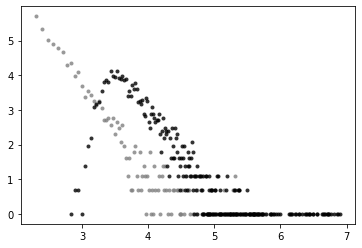

user p_value: 0.7354550854702597 user alpha: 1.7986730959574184 user xmin: 7.0
user p_value: 0.9527960550268729 user alpha: 1.85721291481293 user xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


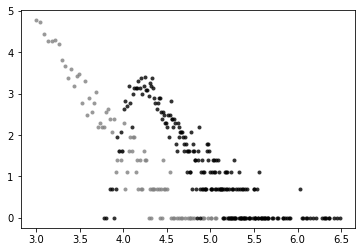

In [13]:
main()

# Class of Assumption Method 2

In [2]:
class assumption_2nd:
    # initializing the whole model
    def __init__(self, beta, iterations, rating_scale, Cu, Ci, Unum, Inum, K, L, C):
        self.init_paramter(beta, iterations, rating_scale, Cu, Ci, Unum, Inum, K, L, C)
        self.init_assumption()
        k = self.stat()
        self.iterate()
        res = self.stat()
        tdu = self.calcdegree_user()
        twu = self.calcweight_user()
        tdi = self.calcdegree_item()
        twi = self.calcweight_item()
        
        k = (res, tdu, twu, tdi, twi)
        x = np.zeros(self.rating_scale)
        self.degseq_user = np.zeros(self.iterations + 1)
        self.weiseq_user = np.zeros(self.iterations + 1)
        self.degseq_item = np.zeros(self.iterations + 1)
        self.weiseq_item = np.zeros(self.iterations + 1)
        
        x[:res.size] = x[:res.size] + res
        self.degseq_user[:min(self.iterations+1,k[1].size)] = self.degseq_user[:min(self.iterations+1,k[1].size)] + k[1][:min(self.iterations+1,k[1].size)]
        self.weiseq_user[:min(self.iterations+1,k[2].size)] = self.weiseq_user[:min(self.iterations+1,k[2].size)] + k[2][:min(self.iterations+1,k[2].size)]
        self.degseq_item[:min(self.iterations+1,k[3].size)] = self.degseq_item[:min(self.iterations+1,k[3].size)] + k[3][:min(self.iterations+1,k[3].size)]
        self.weiseq_item[:min(self.iterations+1,k[4].size)] = self.weiseq_item[:min(self.iterations+1,k[4].size)] + k[4][:min(self.iterations+1,k[4].size)]
        np.set_printoptions(threshold=np.inf)
        xind = np.zeros(self.iterations + 1)
        for i in range(1,self.iterations + 1):
            xind[i] = xind[i-1] + 1
        self.xind_user = xind
        self.xind_item = xind
        print("finish all the staff")
        
    #Initial settings of parameters in our weighted bipartite graph model B(U,I).
    def init_paramter(self, beta, iterations, rating_scale, Cu, Ci, Unum, Inum, K, L, C):
        #Initial settings of parameters in our weighted bipartite graph model B(U,I).
        self.beta = beta # the probability to add a new vertex in U
        self.iterations = iterations # the number of iterations to run the simulation
        self.rating_scale = rating_scale # the preassigned rating scale
        self.Cu = Cu # the least number of edges connected to vertices in U
        self.Ci = Ci # the least number of edges connected to vertices in I
        self.Unum = Unum # the number of vertices in U in the initial graph at t=0
        self.Inum = Inum # the number of vertices in I in the initial graph at t=1
        self.K = K # the number of basic user type in our assumption
        self.L = L # the number of basic item level in our assumption
        
        self.C = C # the number of adding edge
        
        self.Hui = np.zeros((rating_scale,K,L)) # the rating pmf for the pair of K user types and L item levels
        self.Fmean = np.zeros((K,)) # the mean of the distribution of users' weight vector (assumed to be Gaussian)
        self.Gmean = np.zeros((L,)) # the mean of the distribution of items' weight vector (assumed to be Gaussian)
        self.edges = np.zeros((iterations+50,iterations+50), dtype=int) # the matrix storing edge information
        self.Uweight = np.zeros((iterations+50,K)) # the matrix storing users' weight vectors
        self.Iweight = np.zeros((iterations+50,L)) # the matrix storing items' weight vectors
    
    # Initalization of the sampling of edge weights from the mixture distribution
    def init_weightgenerator(self):
        # include K,L,Huser,Hitem,Hui,rating_scale,Fmean,Gmean
        self.Hui = np.random.sample((self.rating_scale, self.K, self.L))
        Huisubsum = np.sum(self.Hui,axis=0)
        Huisubsum = np.array([Huisubsum] * self.rating_scale)
        self.Hui = self.Hui/Huisubsum
        
        self.Huser = np.random.sample((self.K, self.rating_scale))
        Husersubsum = np.sum(self.Huser, axis=1)
        Husersubsum = np.array([Husersubsum] * self.rating_scale)
        Husersubsum = np.transpose(Husersubsum)
        self.Huser = self.Huser/Husersubsum
        
        self.Hitem = np.random.sample((self.L, self.rating_scale))
        Hitemsubsum = np.sum(self.Hitem, axis=1)
        Hitemsubsum = np.array([Hitemsubsum] * self.rating_scale)
        Hitemsubsum = np.transpose(Hitemsubsum)
        self.Hitem = self.Hitem/Hitemsubsum
        
        self.Fmean = np.random.sample(self.K,)
        self.Fmean = self.Fmean/np.sum(self.Fmean)
        self.Gmean = np.random.sample(self.L,)
        self.Gmean = self.Gmean/np.sum(self.Gmean)
    
    #Sample edge weight for the edge between vertices (Uid, Iid)
    def weightgenerator(self, Uid, Iid):
        # include K,L,Huser,Hitem,Hui,rating_scale,Fmean,Gmean
        Uw = self.Uweight[Uid:Uid+1,:]
        Iw = self.Iweight[Iid:Iid+1,:]
        Uw = np.transpose(Uw)
        Hr = np.dot(Uw,Iw)
        Hr = np.array([Hr] * self.rating_scale)
        Hr = self.Hui * Hr
        Hr = np.sum(Hr,axis=1)
        Hr = np.sum(Hr,axis=1)
        R = np.random.choice(self.rating_scale, 1, p=Hr) + 1
        return R
    
    # Initialization for the inital simple graph at t=0
    def init_assumption(self):
        # include edges,Unum,Inum,Uweight,Iweight,K,L,Fmean,Gmean
        print("Initializing...", end="")
        self.init_weightgenerator()
        for i in range(self.Unum):
            Utmp = np.random.normal(self.Fmean, 0.1)
            Utmp[Utmp<0]=0
            Utmp = Utmp/np.sum(Utmp)
            self.Uweight[i,:]=Utmp
        for i in range(self.Inum):
            Itmp = np.random.normal(self.Gmean, 0.1)
            Itmp[Itmp<0]=0
            Itmp = Itmp/np.sum(Itmp)
            self.Iweight[i,:]=Itmp
        self.edges = np.zeros((self.iterations+50, self.iterations+50), dtype=int)
        # We can assume that axis=1 is user sequence and the axis=0 is the item sequence
        for i in range(self.Unum):
            for j in range(self.Inum):
                self.edges[i,j] = self.weightgenerator(i,j)
        print("Done.")
        
    # Select "prototype" from the existing vertex group
    def prototype(self, arr, nb):
        return np.count_nonzero(arr.cumsum() < nb)

    # Conduct Edge-copy and assign new edge weights
    def copyedge(self, template, desired, p_prime):
        ls = []
        new2old = template.nonzero()[0]
        tmp = template[new2old].astype(float)
        for i in range(desired):
            tmp /= tmp.sum()
            sampled = np.nonzero(np.random.multinomial(1, tmp))[0][0]
            ls.append(sampled)
            tmp[sampled] = 0
        ls.sort()
        return new2old[ls]

    # Add new vertices to U (respectively. I)
    def addnode(self, nb_axis):
        # include edges,Unum,Inum,Fmean,Gmean
        weightsum = np.sum(self.edges[:self.Unum,:self.Inum], axis=nb_axis)
        totalsum = np.sum(weightsum)
        randnum = np.random.randint(1, totalsum+1)
        p_prime = self.prototype(weightsum, randnum)
        weighted = np.zeros(1)
        if nb_axis == 1:
            Utmp = np.random.normal(self.Fmean, 0.1)
            Utmp[Utmp<0] = 0
            Utmp = Utmp/np.sum(Utmp)
            self.Uweight[self.Unum,:]=Utmp
            template = self.edges[p_prime,:self.Inum]
            desired = self.Cu
            idx = self.copyedge(template, desired, p_prime)
            new = np.zeros(template.shape[0], dtype=int)
            for i in range(idx.shape[0]):
                new[idx[i]]= self.weightgenerator(self.Unum, idx[i])
            self.edges[self.Unum,:self.Inum] = new
            self.Unum = self.Unum + 1
        else:
            Itmp = np.random.normal(self.Gmean, 0.1)
            Itmp[Itmp<0] = 0
            Itmp = Itmp/np.sum(Itmp)
            self.Iweight[self.Inum,:]=Itmp
            template = self.edges[:self.Unum, p_prime]
            desired = self.Ci
            idx = self.copyedge(template, desired, p_prime)
            new = np.zeros(template.shape[0], dtype=int)
            for i in range(idx.shape[0]):
                new[idx[i]]= self.weightgenerator(idx[i], self.Inum)
            self.edges[:self.Unum,self.Inum] = new
            self.Inum = self.Inum + 1
        
    # Add new edges to Graph
    def addedge(self):
        # include edges,Unum,Inum
        randnum_user = random.randint(1,self.Unum-1)
        randnum_item = random.randint(1,self.Inum-1)
        self.edges[randnum_user,randnum_item] = random.randint(1, self.rating_scale)
        
    # Evolution of U (or I)
    def evolution(self):
        randnum = np.random.rand()
        if randnum < self.beta:
            self.addnode(1)
        else:
            self.addnode(0)
        for i in range(self.C):
            self.addedge()
            # pass

    # Iterate 
    def iterate(self):
        print("Begin iteration...", end="")
        for i in range(self.iterations):
            self.evolution()
        print("Done")

    # Gather statistic information
    def stat(self):
        # include edges
        tmps = self.edges.flatten().astype(int)
        count = np.bincount(tmps)
        count = count[1:]
        count = 1.0*count/count.sum()
        return count

    # Calculate user degree distributions
    def calcdegree_user(self):
        # include edges
        sumdegree = self.edges.astype(bool).sum(axis=1)
        return np.bincount(sumdegree)

    # Calculate user weight distributions
    def calcweight_user(self):
        # include edges
        sumdegree = self.edges.sum(axis=1)
        return np.bincount(sumdegree)

    # Calculate item degree distributions
    def calcdegree_item(self):
        # include edges
        sumdegree = self.edges.astype(bool).sum(axis=0)
        return np.bincount(sumdegree)

    # Calculate item weight distributions
    def calcweight_item(self):
        # include edges
        sumdegree = self.edges.sum(axis=0)
        return np.bincount(sumdegree)
    
    def get_distribution(self, target="user"):
        if target == "item":
            return self.degseq_item, self.weiseq_item, self.xind_item
        else:
            return self.degseq_user, self.weiseq_user, self.xind_user
    
    def get_graph(self):
        return self.edges, self.Inum, self.Unum

In [3]:
def get_pvalue_alpha_xmin(seq):
    results = powerlaw.Fit(seq)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p_value = results.distribution_compare('power_law', 'lognormal')
    print("p_value:", p_value, "alpha:", alpha, "xmin:", xmin)
    return p_value, alpha, xmin

In [6]:
a2 = assumption_2nd(beta=0.8, iterations=4000, rating_scale=5, Cu=10, Ci=20, Unum=20, Inum=10, K=10, L=3, C=1)

Initializing...Done.
Begin iteration...Done
finish all the staff


In [5]:
the_edges, Inum, Unum = a2.get_graph()

In [6]:
print(Inum, Unum)
print(the_edges[:Unum,:Inum], file=open("graph_algo2.txt", "w", encoding="utf8"))

867 3163


## Paramters
 
 - beta = 0.6 
 > the probability to add a new vertex in U
 - iterations = 3000 
 > the number of iterations to run the simulation
 - rating_scale = 5 
 > the preassigned rating scale
 - Cu = 10 
 > the least number of edges connected to vertices in U
 - Ci = 20 
 > the least number of edges connected to vertices in I
 - Unum = 20 
 > the number of vertices in U in the initial graph at t=0
 - Inum = 10 
 > the number of vertices in I in the initial graph at t=1
 - K = 10 
 > the number of basic user type in our assumption
 - L = 3 
 > the number of basic item level in our assumption

# Plot User

In [25]:
degseq, weiseq, xind = a2.get_distribution()
print(len(degseq), len(weiseq), len(xind))

4001 4001 4001


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


user p_value: 0.6380721338655913 user alpha: 1.480916179890841 user xmin: 1.0
user p_value: 0.6489233370429217 user alpha: 1.5772027733642995 user xmin: 1.0


/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


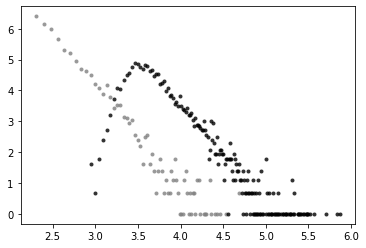

In [26]:
results = powerlaw.Fit(degseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(degseq),'o',color = 'gray', alpha = 0.8, markersize=4, markeredgewidth=0.0)

results = powerlaw.Fit(weiseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(weiseq[:len(xind)]),'o',color = 'black', alpha = 0.8, markersize=4, markeredgewidth=0.0)

# Plot Item

In [27]:
degseq, weiseq, xind = a2.get_distribution("item")

user p_value: 0.35339621362275586 user alpha: 2.401936669657386 user xmin: 12.0
user p_value: 0.44226297128645886 user alpha: 3.273794535984399 user xmin: 6.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13

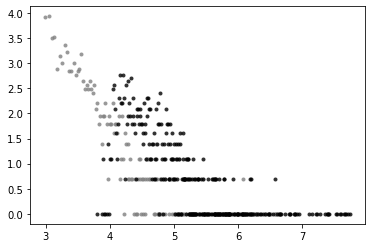

In [28]:
results = powerlaw.Fit(degseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(degseq),'o',color = 'gray', alpha = 0.8, markersize=4, markeredgewidth=0.0)

results = powerlaw.Fit(weiseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(weiseq[:len(xind)]),'o',color = 'black', alpha = 0.8, markersize=4, markeredgewidth=0.0)

# TMC-Needed Images

## 4 pic - User
\beta-\alpha + R-\alpha + c_u-\alpha + c_i-\alpha

In [7]:
beta_list = [0.1,0.2,0.4,0.6,0.8]
rate_list = [1,2,3,4,5,6,7,8,9,10]
cu_list = [1,5,10,20,30,50]
ci_list = [1,5,10,20,30,50]

### $\beta$

In [8]:
alpha_list = []
for item in beta_list:
    print(item)
    a1 = assumption_2nd(beta=item,iterations=4000,rating_scale=5,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_beta_user=pd.DataFrame(data, index=[r'$ \beta $'+' effect '+r'$ \alpha $'], columns=beta_list)
frame_beta_user

0.1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.3509931109518448 alpha: 2.298388831159261 xmin: 4.0
0.2
Initializing...

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Done.
Begin iteration...Done
finish all the staff
p_value: 0.3302512217543211 alpha: 1.9499027471147539 xmin: 2.0
0.4
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.3980146359971377 alpha: 1.9101891498463714 xmin: 1.0
0.6
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.25909500534120755 alpha: 1.6454006492529236 xmin: 1.0
0.8
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.7550701120435905 alpha: 1.474714299995532 xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


,0.1,0.2,0.4,0.6,0.8
$ \beta $ effect $ \alpha $,2.298389,1.949903,1.910189,1.645401,1.474714


### $rate$

In [9]:
alpha_list = []
for item in rate_list:
    print(item)
    a1 = assumption_2nd(beta=0.6,iterations=4000,rating_scale=item,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_rate_user=pd.DataFrame(data, index=['rate'+' effect '+r'$ \alpha $'], columns=rate_list)
frame_rate_user

1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.3151880019995965 alpha: 1.6795175586768827 xmin: 1.0
2
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.7044453946543296 alpha: 1.7717458269719226 xmin: 11.0
3
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.48345592521273717 alpha: 1.6166158771774035 xmin: 3.0
4
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.5755121894951636 alpha: 1.7507389094629817 xmin: 11.0
5
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.26171627251509333 alpha: 1.700497171223918 xmin: 1.0
6
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.28010492058077896 alpha: 2.2989389569687946 xmin: 87.0
7
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.7099584868666473 alpha: 1.6037273811417116 xmin: 2.0
8
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.47805865490638677 alpha: 1.7434255427560776 xmin: 1.0
9
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.28917748047310243 alpha: 1.698627130215326 xmin: 1.0
10
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.511548091501483 alpha: 1.624857019109002 xmin: 3.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


,1,2,3,4,5,6,7,8,9,10
rate effect $ \alpha $,1.679518,1.771746,1.616616,1.750739,1.700497,2.298939,1.603727,1.743426,1.698627,1.624857


### $C_{u}$

In [10]:
alpha_list = []
for item in cu_list:
    print(item)
    a1 = assumption_2nd(beta=0.6,iterations=4000,rating_scale=5,Cu=item,Ci=20,Unum=20,Inum=50,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_cu_user=pd.DataFrame(data, index=[r'$ c_{u} $'+' effect '+r'$ \alpha $'], columns=cu_list)
frame_cu_user

1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.8109731660956835 alpha: 1.763345936786736 xmin: 1.0
5
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.5531587914950234 alpha: 1.6671489798683794 xmin: 8.0
10
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.8102539703458709 alpha: 1.6143673092082595 xmin: 1.0
20
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.3067651547380753 alpha: 2.7674650944818495 xmin: 101.0
30
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.3554592096990967 alpha: 2.8751439954417517 xmin: 96.0
50
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.35972427859891976 alpha: 1.57677965919386 xmin: 2.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


,1,5,10,20,30,50
$ c_{u} $ effect $ \alpha $,1.763346,1.667149,1.614367,2.767465,2.875144,1.57678


### $C_{i}$

In [11]:
alpha_list = []
for item in ci_list:
    print(item)
    a1 = assumption_2nd(beta=0.6,iterations=4000,rating_scale=5,Cu=10,Ci=item,Unum=50,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_ci_user=pd.DataFrame(data, index=[r'$ c_{i} $'+' effect '+r'$ \alpha $'], columns=ci_list)
frame_ci_user

1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.4161322333480668 alpha: 1.6255863293909634 xmin: 45.0
5
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.46252879870134955 alpha: 1.708422258667185 xmin: 30.0
10
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.3379622749958511 alpha: 1.532307215512982 xmin: 2.0
20
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.41296525144149665 alpha: 1.7288633480887012 xmin: 1.0
30
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.9320819847027689 alpha: 1.697402190347125 xmin: 2.0
50
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.7360272320141518 alpha: 1.788253280863965 xmin: 6.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


,1,5,10,20,30,50
$ c_{i} $ effect $ \alpha $,1.625586,1.708422,1.532307,1.728863,1.697402,1.788253


## 4 pic - Item
 - $\beta-\alpha$
 - $R-\alpha$
 - $c_{u}-\alpha$
 - $c_{i}-\alpha$

In [12]:
beta_list = [0.1,0.2,0.4,0.6,0.8]
rate_list = [1,2,3,4,5,6,7,8,9,10]
cu_list = [1,5,10,20,30,50]
ci_list = [1,5,10,20,30,50]

### $\beta$

In [13]:
alpha_list = []
for item in beta_list:
    print(item)
    a1 = assumption_2nd(beta=item,iterations=4000,rating_scale=5,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution("item")
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_beta_item=pd.DataFrame(data, index=[r'$ \beta $'+' effect '+r'$ \alpha $'], columns=beta_list)
frame_beta_item

0.1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.3787915793389859 alpha: 1.469606093929218 xmin: 14.0
0.2
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.3031395820796755 alpha: 1.5612680640877077 xmin: 17.0
0.4
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.6436527563366021 alpha: 1.4912072461877293 xmin: 1.0
0.6
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.3130438482380341 alpha: 2.06718368004982 xmin: 20.0
0.8
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.30077047818091784 alpha: 2.0331678609745047 xmin: 4.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,0.1,0.2,0.4,0.6,0.8
$ \beta $ effect $ \alpha $,1.469606,1.561268,1.491207,2.067184,2.033168


### $rate$

In [14]:
alpha_list = []
for item in rate_list:
    print(item)
    a1 = assumption_2nd(beta=0.6,iterations=4000,rating_scale=item,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_rate_item=pd.DataFrame(data, index=['rate'+' effect '+r'$ \alpha $'], columns=rate_list)
frame_rate_item

1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.9373473667601977 alpha: 2.123813244559408 xmin: 47.0
2
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.2537797780713903 alpha: 1.731298756682138 xmin: 1.0
3
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.28699407666222676 alpha: 1.7122449519645495 xmin: 1.0
4
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.6324464797342599 alpha: 1.6815246736263245 xmin: 1.0
5
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.8534610286819488 alpha: 1.7189075451071696 xmin: 1.0
6
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.65869212592049 alpha: 1.6272539486117796 xmin: 2.0
7
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.25425955265363875 alpha: 1.7418650549207246 xmin: 1.0
8
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.3264590552090043 alpha: 1.7416792686872298 xmin: 1.0
9
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.8255824003764545 alpha: 1.6337719753523638 xmin: 2.0
10
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.256965428495184 alpha: 1.747196519202817 xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,1,2,3,4,5,6,7,8,9,10
rate effect $ \alpha $,2.123813,1.731299,1.712245,1.681525,1.718908,1.627254,1.741865,1.741679,1.633772,1.747197


### $C_{u}$

In [15]:
alpha_list = []
for item in cu_list:
    print(item)
    a1 = assumption_2nd(beta=0.6,iterations=4000,rating_scale=5,Cu=item,Ci=20,Unum=20,Inum=50,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_cu_item=pd.DataFrame(data, index=[r'$ c_{u} $'+' effect '+r'$ \alpha $'], columns=cu_list)
frame_cu_item

1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.9965669173940129 alpha: 1.5934158900741937 xmin: 2.0
5
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.533635753412161 alpha: 1.6574254051117778 xmin: 8.0
10
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.8928226174040776 alpha: 1.651191559444678 xmin: 1.0
20
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.9612427695525843 alpha: 2.271005647303574 xmin: 62.0
30
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.2979284913902507 alpha: 2.39180676945239 xmin: 54.0
50
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.29604646717054917 alpha: 2.4814472926294258 xmin: 57.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,1,5,10,20,30,50
$ c_{u} $ effect $ \alpha $,1.593416,1.657425,1.651192,2.271006,2.391807,2.481447


### $C_{i}$

In [16]:
alpha_list = []
for item in ci_list:
    print(item)
    a1 = assumption_2nd(beta=0.6,iterations=4000,rating_scale=5,Cu=10,Ci=item,Unum=50,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_ci_item=pd.DataFrame(data, index=[r'$ c_{i} $'+' effect '+r'$ \alpha $'], columns=ci_list)
frame_ci_item

1
Initializing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.5209392906211648 alpha: 1.631042247023664 xmin: 38.0
5
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.23226902881564526 alpha: 1.5183029768407161 xmin: 7.0
10
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.5680147758115246 alpha: 1.621968844558615 xmin: 5.0
20
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.10477651430974531 alpha: 1.7309658331608797 xmin: 2.0
30
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.739969940754998 alpha: 1.6478969876030034 xmin: 2.0
50
Initializing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.2490236660026831 alpha: 2.4708428261550397 xmin: 74.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,1,5,10,20,30,50
$ c_{i} $ effect $ \alpha $,1.631042,1.518303,1.621969,1.730966,1.647897,2.470843
